In [2]:
import talos
import os
import numpy as np
from code.preprocessing import prepare_te_data
from code.models.utils import SequenceGenerator
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [5]:
BASE_PATH = 'code/output/hyperoptim/2020-04-20-16-30-31'
PACKAGE_PATH = f'{BASE_PATH}/cnn.zip'
REPORT_PATH = f'{BASE_PATH}/042020163259.csv'
RANDOM_SEED = 42

In [6]:
DATA_DIR = '../data/'
TE_PATH = os.path.join(DATA_DIR, 'csv', 'te_LMCN.v2.csv')
TE_SAMPLE_NAME = 'CN34_S5_r1_te.h.trim.uncontam'
RNA_PATH = os.path.join(DATA_DIR, 'csv', 'preprocessed.csv')

# Analyze

In [7]:
analyze = talos.Analyze(REPORT_PATH)
analyze.data.sort_values('val_rmse')

round_epochs  val_loss  val_rmse      loss      rmse  ...  inner_conv_size     lr  optimizer  pool_size      vocab_lengths
0           230  0.006757  0.028589  0.000153  0.008587  ...                9  0.001       adam          2  [5, 66, 23, None]
5           104  0.001406  0.030498  0.002979  0.033839  ...                7  0.001       adam          3  [5, 66, 23, None]
4           103  0.001750  0.031020  0.003125  0.034737  ...                7  0.001       adam          2  [5, 66, 23, None]
3           341  0.019746  0.031139  0.001934  0.029421  ...                7  0.001       adam          3  [5, 66, 23, None]
2           167  0.015177  0.032659  0.000625  0.018006  ...                7  0.001       adam          2  [5, 66, 23, None]
6           401  0.007462  0.035004  0.000332  0.013687  ...                3  0.001       adam          3  [5, 66, 23, None]
1           262  0.002186  0.039967  0.001230  0.024192  ...                9  0.001       adam          2  [5, 66, 23, None]

[7 rows x 18 columns]

In [8]:
analyze.low('val_rmse')

0.028588715940713882

In [9]:
analyze.correlate('val_rmse', exclude=[])

round_epochs       0.366055
val_loss          -0.197753
loss              -0.207125
rmse              -0.030281
batch_size        -0.281052
conv_dropout      -0.117244
conv_filters      -0.103518
dense_dim         -0.632743
dense_dropout      0.438093
embedding_size     0.206750
epochs                  NaN
first_conv_size   -0.545550
inner_conv_size   -0.064253
lr                      NaN
pool_size         -0.119945
Name: val_rmse, dtype: float64

findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans.


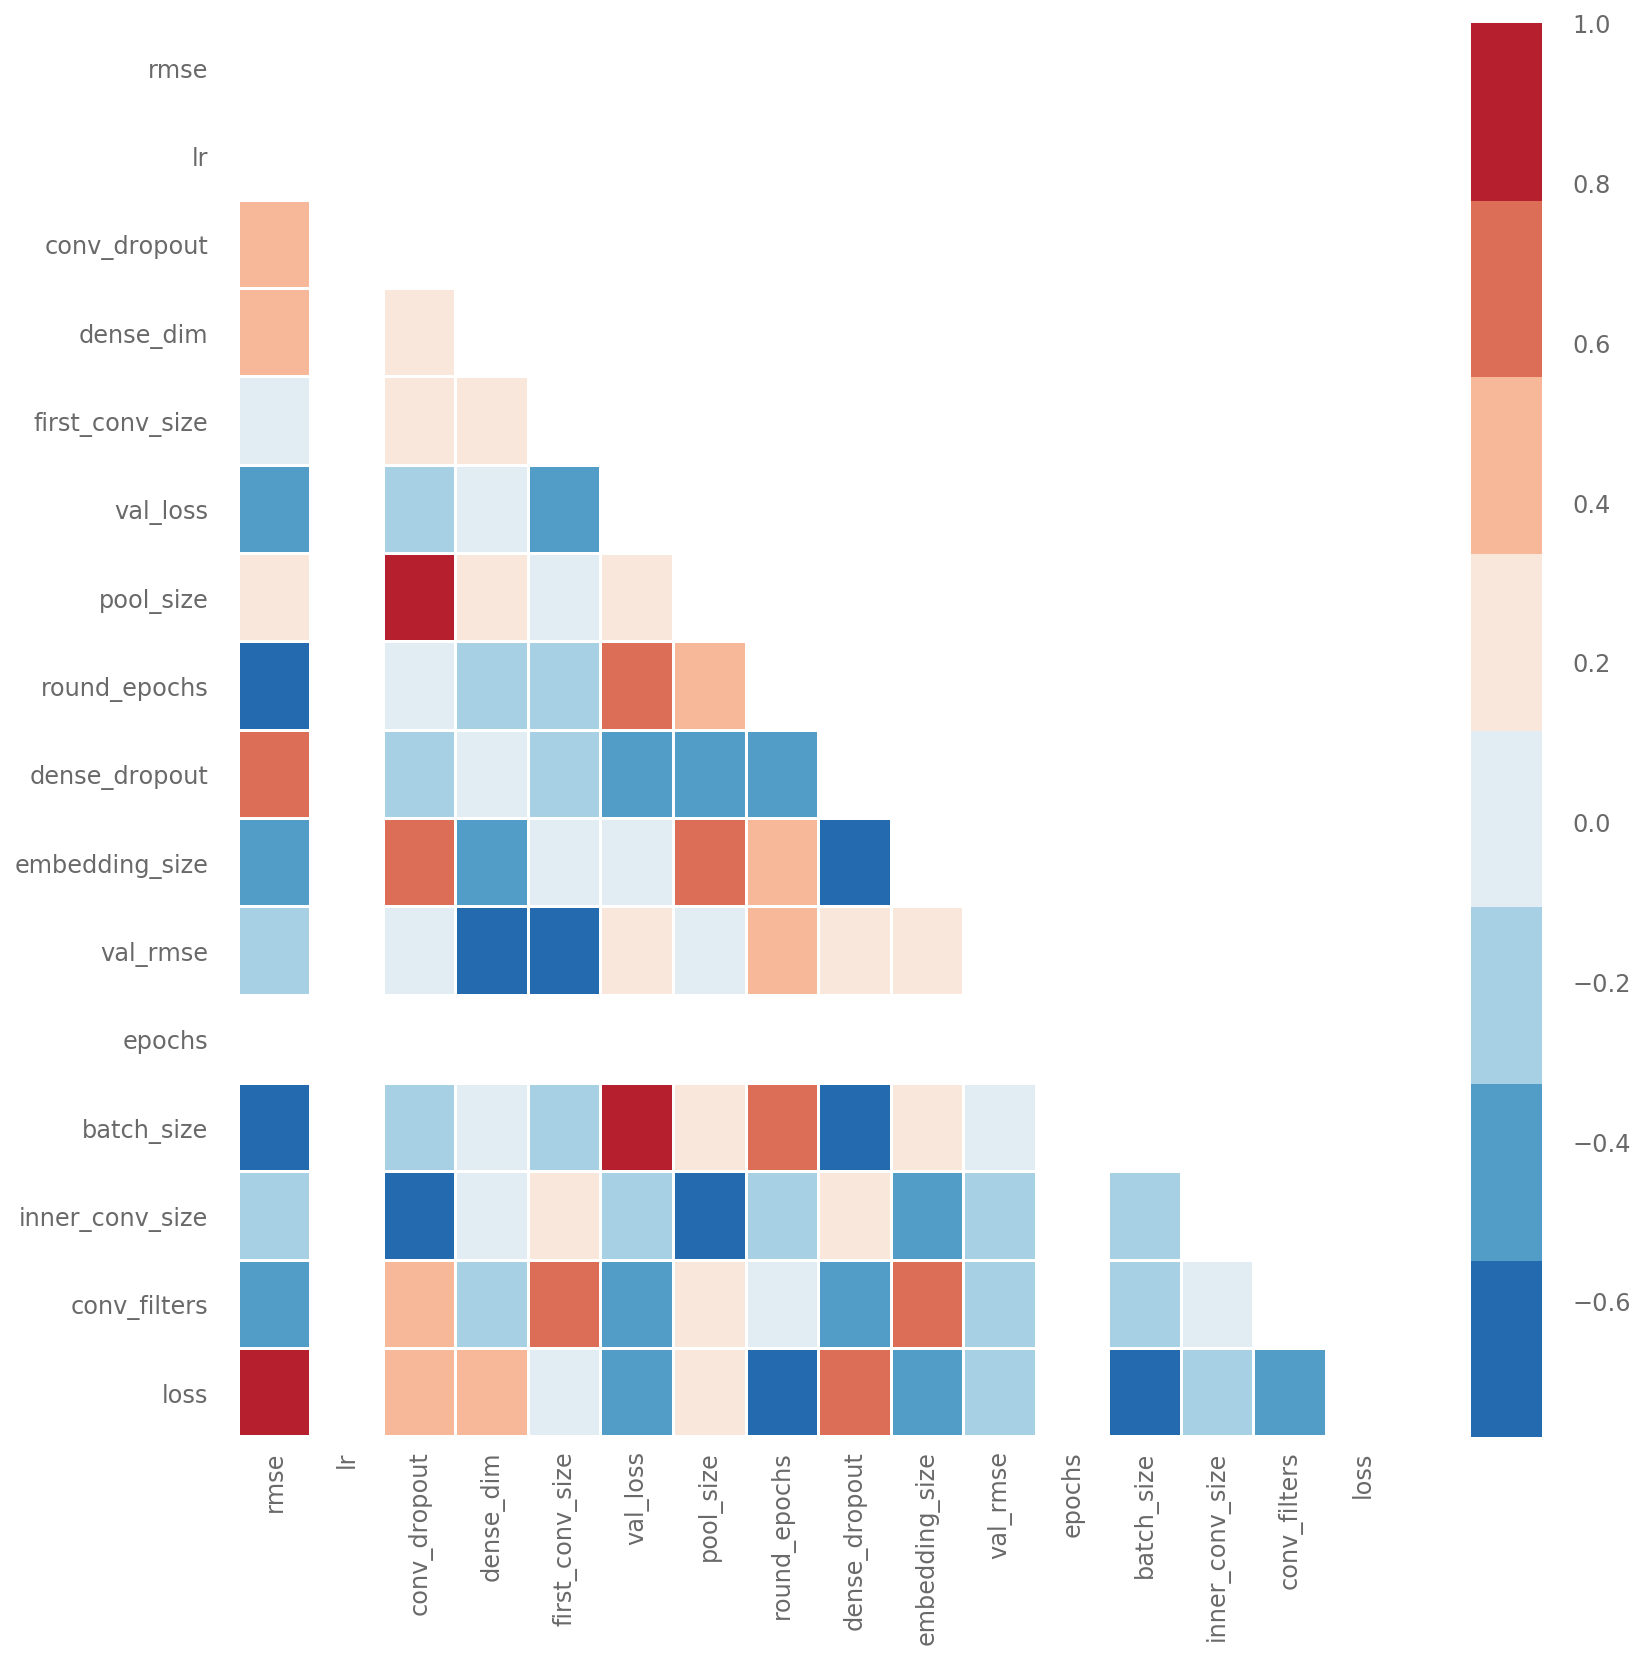

In [10]:
analyze.plot_corr('val_rmse', exclude=[])

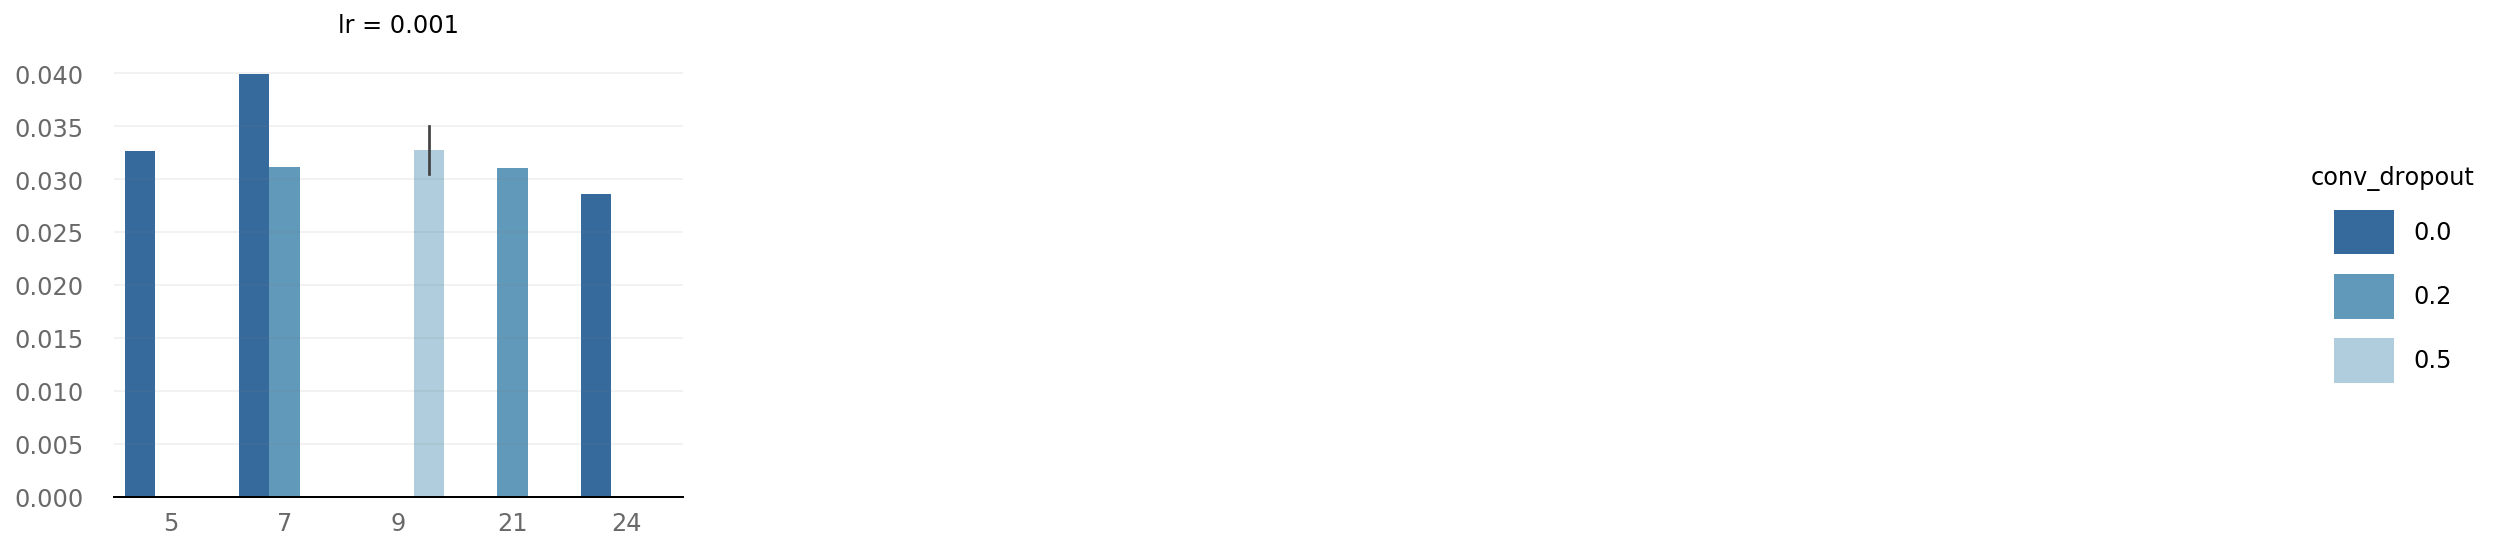

In [11]:
analyze.plot_bars('first_conv_size', 'val_rmse', 'conv_dropout', 'lr')

In [12]:
analyze.plot_bars('inner_conv_size', 'val_rmse', 'conv_dropout', 'lr')

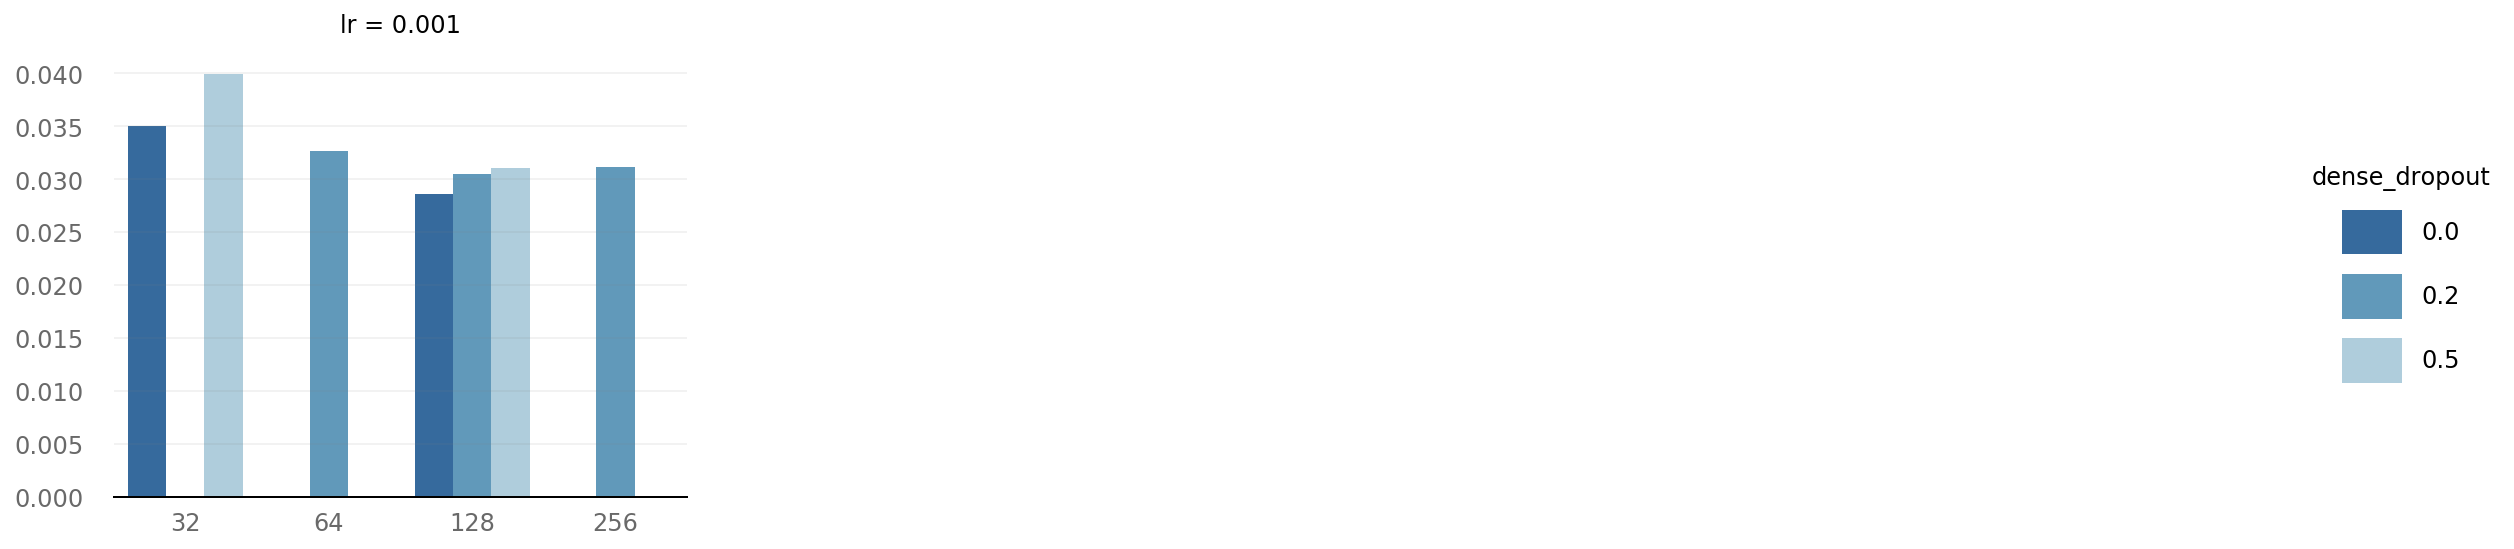

In [13]:
analyze.plot_bars('dense_dim', 'val_rmse', 'dense_dropout', 'lr')

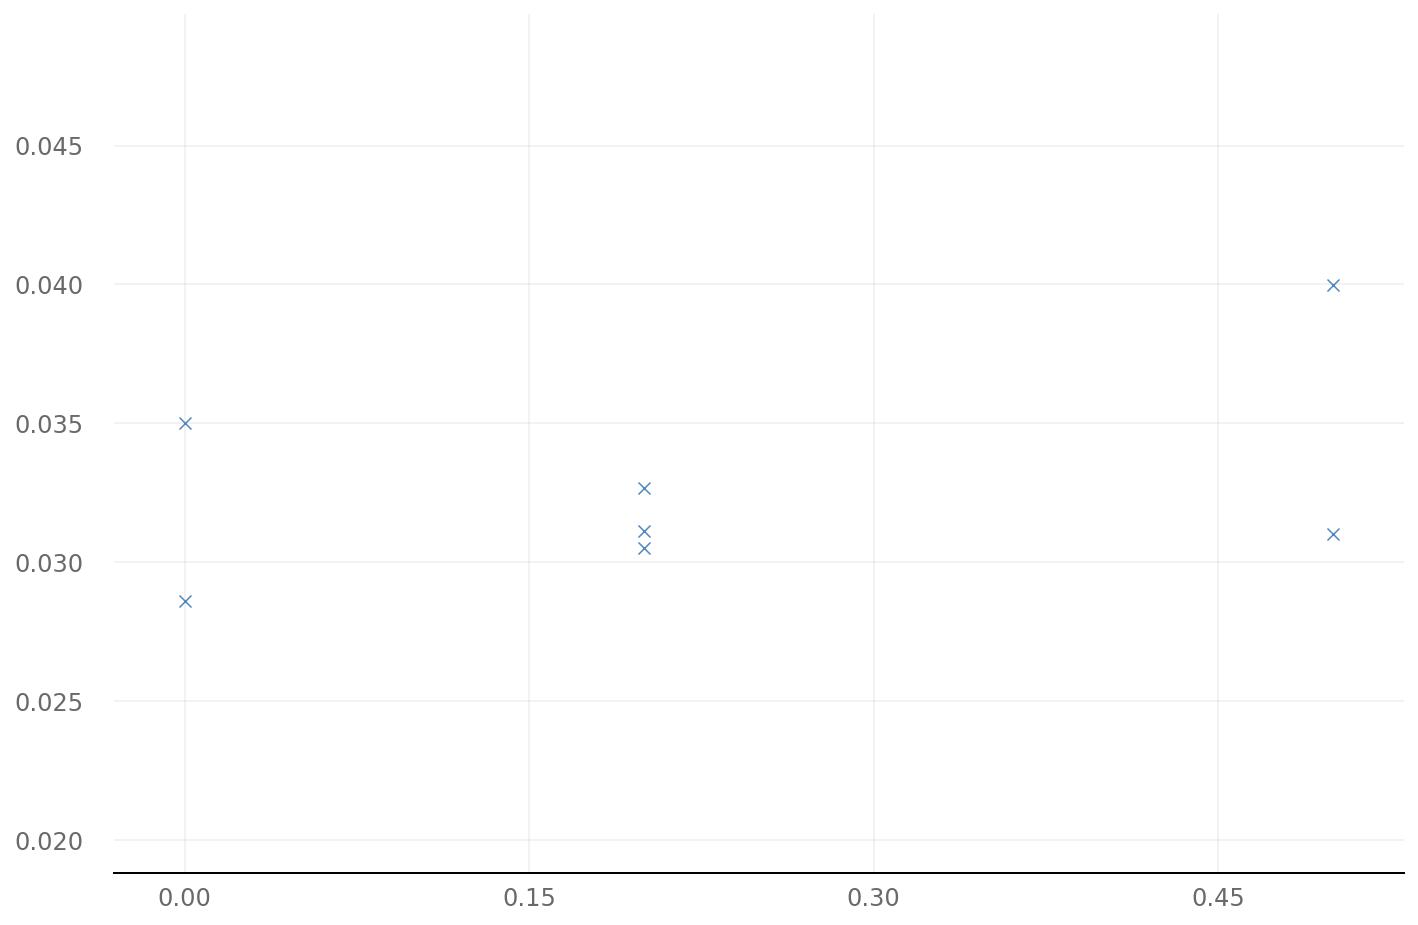

In [14]:
analyze.plot_regs('dense_dropout', 'val_rmse')

# Best Models

In [15]:
experiment = talos.Restore(PACKAGE_PATH)
experiment.details

0                                      1
0                   NaN                                      0
1       experiment_name  output/hyperoptim/2020-04-20-16-30-31
2         random_method                       uniform_mersenne
3      reduction_method                            correlation
4    reduction_interval                                     20
5      reduction_window                                     20
6   reduction_threshold                                    0.2
7      reduction_metric                               val_rmse
8         complete_time                         04/21/20/06:47
9               x_shape                              (7812, 4)
10              y_shape                                (7812,)

In [16]:
experiment.params

{'optimizer': ['adam'],
 'batch_size': [32, 64],
 'epochs': [1000],
 'lr': [0.001],
 'vocab_lengths': [[5, 66, 23, None]],
 'embedding_size': [8, 16, 32, 64],
 'conv_filters': [8, 16, 32, 64],
 'first_conv_size': [5, 7, 9, 15, 21, 24],
 'inner_conv_size': [3, 5, 7, 9],
 'conv_dropout': [0, 0.2, 0.5],
 'pool_size': [2, 3],
 'dense_dim': [32, 64, 128, 256, 512],
 'dense_dropout': [0, 0.2, 0.5]}

In [17]:
x_train, y_train, x_val, y_val, x_test, y_test, word_indices = prepare_te_data(RNA_PATH, TE_PATH, TE_SAMPLE_NAME,
                                                                               max_length=6000, random_seed=RANDOM_SEED)

In [18]:
x_test.shape, y_test.shape

((965, 4), (965,))

In [19]:
def plot_reg(x, y, model):
    y_pred = model.predict_generator(SequenceGenerator(x, y))
    ax = sns.jointplot(np.log1p(y.ravel()), np.log1p(y_pred.ravel()),
                       kind='reg', stat_func=stats.spearmanr, marker='.');
    plt.xlabel('ground truth');
    plt.ylabel('prediction');

In [20]:
plot_reg(x_train, y_train, experiment.model)

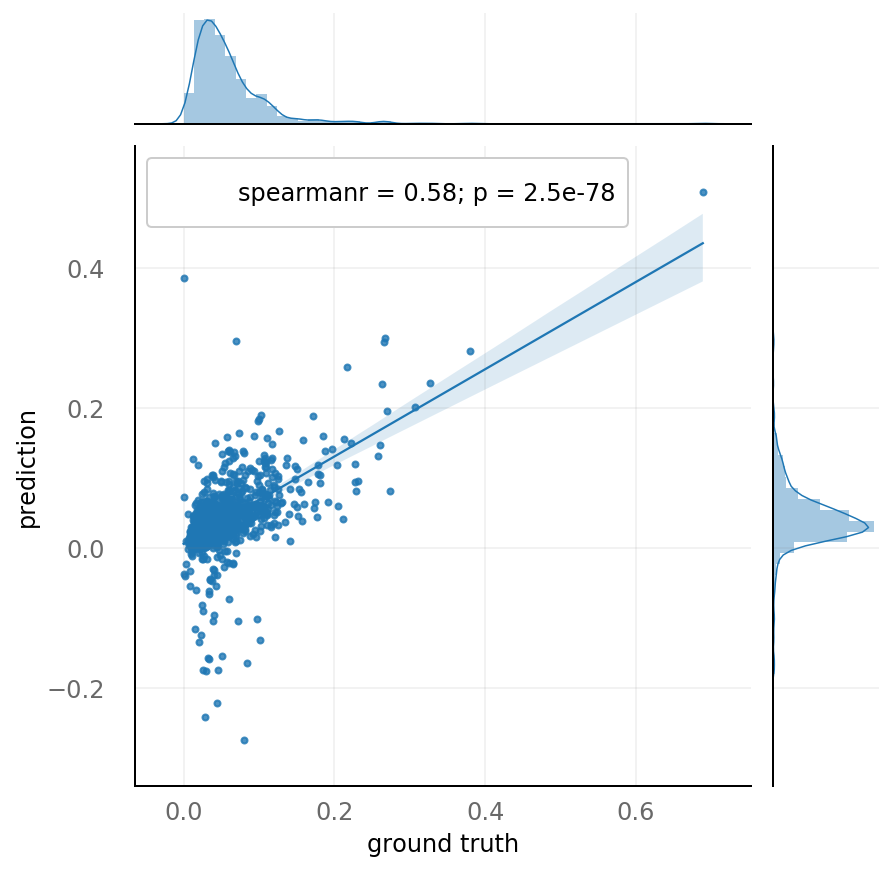

In [21]:
plot_reg(x_val, y_val, experiment.model)

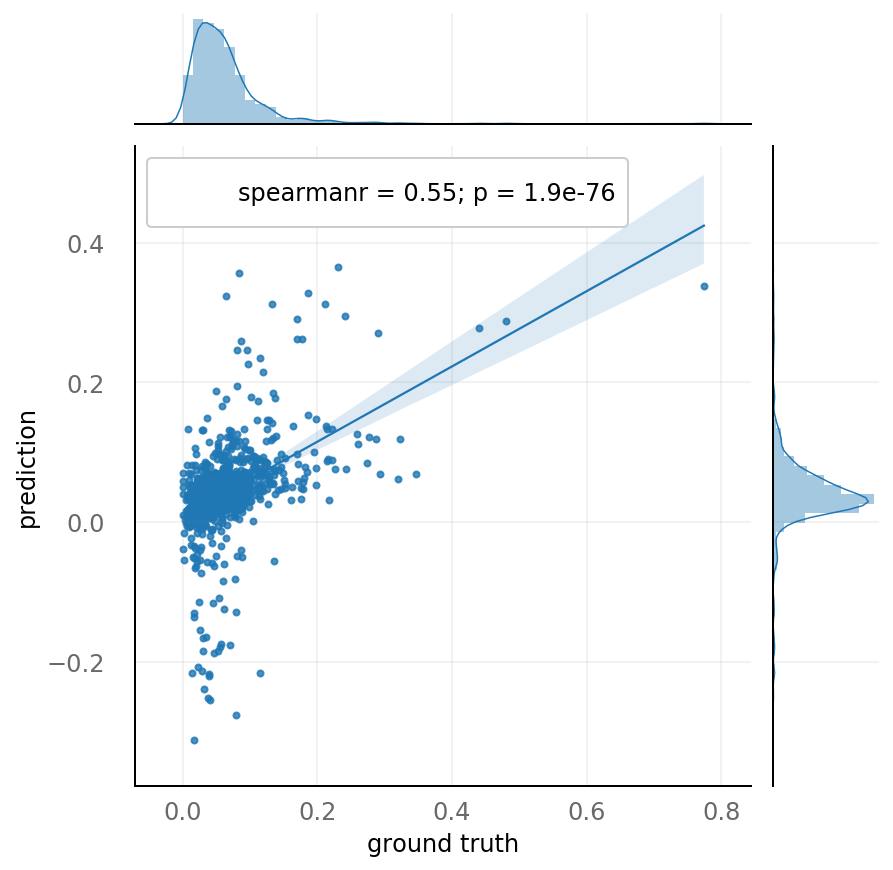

In [22]:
plot_reg(x_test, y_test, experiment.model)